In [59]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import string
import csv
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

data_path = 'data/data.csv'

tweet_tokenizer = TweetTokenizer()

tweet_data = []

with open(data_path) as f:
    reader = csv.reader(f, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    tweet_data = list(reader)

parsed_tweet = []

# stop words
stop = set(stopwords.words('russian'))

In [60]:
emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)

patt1 = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
patt2 = re.compile(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')

for info in tweet_data:
    # delete links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', unicode(info[0].lower(), 'utf-8'), flags=re.MULTILINE)
    # delete emojis
    text = emoji_pattern.sub(r'', text) # no emoji
    text = patt1.sub(r'', text) # no emoji
    text = patt2.sub(r'', text) # no emoji
    
    # delete @
    # delete #
    l = " ".join(tweet_tokenizer.tokenize(text)).split(" ")
    filtered_sentence = [w for w in l if not w in stop and not w in string.punctuation 
                         and ( w[0] != '@' and w[0] != '#')]
    parsed_tweet.append(filtered_sentence)

# creates a corpus with each document having one string

for i in range(len(parsed_tweet)):
    parsed_tweet[i] = ' '.join(parsed_tweet[i])    

# label the data

tweet_target = np.zeros(len(tweet_data))

labels = {
    'Предложение проституции': 0,
    'Разжигание межнациональной розни': 1,
    'Оскорбление чувств верующих': 2,
    'Посты политической направленности': 3,
    'Продажа наркотиков': 4
}

labels_list = [key for key in labels]
labels_list_two = ['prostitution', 'mezhnac', 'vera', 'politic', 'drugs']


for i in range(len(tweet_data)):
    tweet_target[i] = labels[tweet_data[i][1]]

('\taccuracy test: ', 0.9487951807228916)
[[ 70   0   0   0   0]
 [  0  26   6   2   0]
 [  0   0  35   1   0]
 [  0   5   2  27   0]
 [  0   1   0   0 157]]
              precision    recall  f1-score   support

prostitution       1.00      1.00      1.00        70
     mezhnac       0.81      0.76      0.79        34
        vera       0.81      0.97      0.89        36
     politic       0.90      0.79      0.84        34
       drugs       1.00      0.99      1.00       158

 avg / total       0.95      0.95      0.95       332



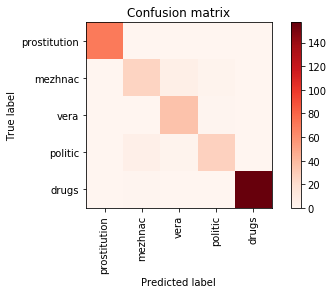

In [61]:
total_svm = 0
""" 
80% Training , 20% Testing
"""

twenty_percent = len(tweet_data) * 0.2

X_train, X_test, y_train, y_test = train_test_split(parsed_tweet, tweet_target, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)

# Returns a feature vectors matrix having a fixed length tf-idf weighted word count feature
# for each document in training set. aka Term-document matrix

train_corpus_tf_idf = vectorizer.fit_transform(X_train)
test_corpus_tf_idf = vectorizer.transform(X_test)

model1 = LinearSVC()
model1.fit(train_corpus_tf_idf, y_train)

result1 = model1.predict(test_corpus_tf_idf)

print("\taccuracy test: ", accuracy_score(y_test, result1))

cnf_matrix = confusion_matrix(y_test, result1)
print(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, labels_list_two)

print(classification_report(y_test, result1, target_names=labels_list_two))

In [62]:

errors_first = {i:0 for i in set(y_test)}
errors_second = {i: 0 for i in set(y_test)}
count_documents = {i:0 for i in set(y_test)}

all_size = len(X_test)

# ошибки первого и второго рода
for i in range(len(result1)):
    if(result1[i] != y_test[i]):
        errors_first[result1[i]] += 1
        errors_second[y_test[i]] += 1
    count_documents[y_test[i]] += 1

for i in errors_first:
    # ошибка первого рода, ошибка второго рода, процент категории от общего количества текстов
    print(i, '|', errors_first[i] / float(count_documents[i]) * 100, '%', '|', errors_second[i] /
float(count_documents[i]) * 100, '|', float(count_documents[i]) / all_size * 100)
  

(0.0, '|', 0.0, '%', '|', 0.0, '|', 21.084337349397593)
(1.0, '|', 17.647058823529413, '%', '|', 23.52941176470588, '|', 10.240963855421686)
(2.0, '|', 22.22222222222222, '%', '|', 2.7777777777777777, '|', 10.843373493975903)
(3.0, '|', 8.823529411764707, '%', '|', 20.588235294117645, '|', 10.240963855421686)
(4.0, '|', 0.0, '%', '|', 0.6329113924050633, '|', 47.59036144578313)


In [63]:
total_svm = 0

# initialize the K-cross fold validation

kf = StratifiedKFold(n_splits=10)

for train_index, test_index in kf.split(parsed_tweet, tweet_target):
    X_train = [parsed_tweet[i] for i in train_index]
    X_test = [parsed_tweet[i] for i in test_index]
    y_train, y_test = tweet_target[train_index], tweet_target[test_index]
    vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)
    train_corpus_tf_idf = vectorizer.fit_transform(X_train)
    test_corpus_tf_idf = vectorizer.transform(X_test)
    
    model1 = LinearSVC()
    model1.fit(train_corpus_tf_idf, y_train)
    result1 = model1.predict(test_corpus_tf_idf)
    
    total_svm = total_svm + sum(y_test == result1)
    

print('AVG K-cross validation: ', float(total_svm)/len(tweet_data))

('AVG K-cross validation: ', 0.9305555555555556)
